# **LearningRate fijo (Adagrad)**

## **Importar dataset**

In [97]:
import kagglehub    # Libreria para la descarga de archivos de kaggle

# Download latest version
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/railway-track-fault-detection-resized-224-x-224


## **Directorios**

In [98]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [99]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [100]:
def modelo_base ():
  VGG16_Base = (tf.keras.applications.VGG16(include_top=False,        # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.
  # Congelamos el modelo.
  for layer in VGG16_Base.layers:
    layer.trainable = False
  return VGG16_Base

## **Entrenamiento**

### Datos de entrada

In [101]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
datagen = ImageDataGenerator(rescale=1./255)

# Definimos los generadores para cada uno de los conjuntos.
train_data = datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_data = datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_data = datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16 (0.01)

In [103]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_001.add(tf.keras.layers.Flatten())
VGG16_001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_001.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [104]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [105]:
# Compilamos el modelo antes definido.
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_start_time = time.time()
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=20,
    validation_data=validation_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - acc: 0.5262 - loss: 4.8851 - val_acc: 0.5000 - val_loss: 0.8400
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - acc: 0.4884 - loss: 0.8834 - val_acc: 0.5000 - val_loss: 0.7060
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - acc: 0.6168 - loss: 0.6352 - val_acc: 0.5000 - val_loss: 0.8398
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.5951 - loss: 0.6490 - val_acc: 0.6290 - val_loss: 0.6120
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - acc: 0.5901 - loss: 0.6556 - val_acc: 0.6290 - val_loss: 0.6085
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - acc: 0.5967 - loss: 0.6599 - val_acc: 0.8065 - val_loss: 0.5500
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - acc: 0.6548 - loss: 0.6159 - val_acc: 0.7581 - val_loss: 0.5584
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - acc: 0.7647 - loss: 0.5546 - val_acc: 0.7581 - val_loss: 0.5187
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - ac

In [106]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc1 = VGG16_001_history.history['acc']
VGG16_001_val_acc1 = VGG16_001_history.history['val_acc']
VGG16_001_loss1 = VGG16_001_history.history['loss']
VGG16_001_val_loss1 = VGG16_001_history.history['val_loss']

In [107]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_001_end_time - VGG16_001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - acc: 0.5852 - loss: 0.7452 - val_acc: 0.7097 - val_loss: 0.5419
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - acc: 0.7361 - loss: 0.5145 - val_acc: 0.5000 - val_loss: 1.9452
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - acc: 0.7212 - loss: 0.8914 - val_acc: 0.8065 - val_loss: 0.4697
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - acc: 0.9072 - loss: 0.2911 - val_acc: 0.5484 - val_loss: 0.9464
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - acc: 0.7638 - loss: 0.4814 - val_acc: 0.7903 - val_loss: 0.5431
Tiempo de ejecución: 100.4079921245575 segundos


In [108]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc2 = VGG16_001_history.history['acc']
VGG16_001_val_acc2 = VGG16_001_history.history['val_acc']
VGG16_001_loss2 = VGG16_001_history.history['loss']
VGG16_001_val_loss2 = VGG16_001_history.history['val_loss']

### Modelo VGG16 (0.005)

In [109]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0005 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0005.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0005.add(tf.keras.layers.Flatten())
VGG16_0005.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0005.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [110]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [111]:
# Compilamos el modelo antes definido.
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_start_time = time.time()
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=20,
    validation_data=validation_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - acc: 0.4982 - loss: 2.1021 - val_acc: 0.5000 - val_loss: 0.7369
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - acc: 0.5120 - loss: 0.7162 - val_acc: 0.7097 - val_loss: 0.6391
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - acc: 0.6088 - loss: 0.6577 - val_acc: 0.5000 - val_loss: 0.8427
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - acc: 0.6347 - loss: 0.6672 - val_acc: 0.5000 - val_loss: 0.6756
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - acc: 0.6181 - loss: 0.6411 - val_acc: 0.7581 - val_loss: 0.5844
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - acc: 0.7844 - loss: 0.5653 - val_acc: 0.7581 - val_loss: 0.5418
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - acc: 0.6262 - loss: 0.6341 - val_acc: 0.5484 - val_loss: 0.6854
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - acc: 0.6305 - loss: 0.6155 - val_acc: 0.5000 - val_loss: 0.7524
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - ac

In [112]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc1 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc1 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss1 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss1 = VGG16_0005_history.history['val_loss']

In [113]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0005_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0005_end_time - VGG16_0005_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - acc: 0.6775 - loss: 0.6894 - val_acc: 0.7419 - val_loss: 0.5153
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - acc: 0.8191 - loss: 0.4253 - val_acc: 0.7419 - val_loss: 0.4840
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - acc: 0.8037 - loss: 0.3995 - val_acc: 0.8548 - val_loss: 0.4390
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - acc: 0.8939 - loss: 0.2571 - val_acc: 0.8387 - val_loss: 0.4010
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.8324 - loss: 0.4186 - val_acc: 0.8387 - val_loss: 0.4108
Tiempo de ejecución: 79.55632066726685 segundos


In [114]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc2 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc2 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss2 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss2 = VGG16_0005_history.history['val_loss']

### Modelo VGG16 (0.001)

In [115]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0001.add(tf.keras.layers.Flatten())
VGG16_0001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0001.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [116]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [117]:
# Compilamos el modelo antes definido.
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_start_time = time.time()
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=20,
    validation_data=validation_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - acc: 0.5190 - loss: 1.0809 - val_acc: 0.6452 - val_loss: 0.6438
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - acc: 0.5582 - loss: 0.6567 - val_acc: 0.5968 - val_loss: 0.6259
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - acc: 0.6707 - loss: 0.6105 - val_acc: 0.7903 - val_loss: 0.5794
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.8136 - loss: 0.5496 - val_acc: 0.5968 - val_loss: 0.6005
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.6899 - loss: 0.5482 - val_acc: 0.7742 - val_loss: 0.5419
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - acc: 0.7598 - loss: 0.4969 - val_acc: 0.7581 - val_loss: 0.5350
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - acc: 0.8150 - loss: 0.4782 - val_acc: 0.7742 - val_loss: 0.5223
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - acc: 0.8359 - loss: 0.4430 - val_acc: 0.8065 - val_loss: 0.4871
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - ac

In [118]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc1 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc1 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss1 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss1 = VGG16_0001_history.history['val_loss']

In [119]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0001_end_time - VGG16_0001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - acc: 0.7562 - loss: 0.5874 - val_acc: 0.8065 - val_loss: 0.4455
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - acc: 0.9421 - loss: 0.2701 - val_acc: 0.6613 - val_loss: 0.5635
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - acc: 0.8465 - loss: 0.3507 - val_acc: 0.7097 - val_loss: 0.5849
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - acc: 0.9726 - loss: 0.2340 - val_acc: 0.8710 - val_loss: 0.4084
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - acc: 0.9349 - loss: 0.2498 - val_acc: 0.8710 - val_loss: 0.4005
Tiempo de ejecución: 71.95813632011414 segundos


In [120]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc2 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc2 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss2 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss2 = VGG16_0001_history.history['val_loss']

### Modelo VGG16 (0.0001)

In [121]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_00001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_00001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_00001.add(tf.keras.layers.Flatten())
VGG16_00001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_00001.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [122]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [123]:
# Compilamos el modelo antes definido.
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_start_time = time.time()
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=20,
    validation_data=validation_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - acc: 0.4787 - loss: 0.7476 - val_acc: 0.4677 - val_loss: 0.7108
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - acc: 0.5974 - loss: 0.6802 - val_acc: 0.5645 - val_loss: 0.6886
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.5904 - loss: 0.6661 - val_acc: 0.6452 - val_loss: 0.6712
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - acc: 0.6625 - loss: 0.6532 - val_acc: 0.5806 - val_loss: 0.6625
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - acc: 0.6616 - loss: 0.6285 - val_acc: 0.6452 - val_loss: 0.6502
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - acc: 0.6968 - loss: 0.6196 - val_acc: 0.7097 - val_loss: 0.6394
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - acc: 0.7118 - loss: 0.6260 - val_acc: 0.7419 - val_loss: 0.6304
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - acc: 0.6993 - loss: 0.6080 - val_acc: 0.7419 - val_loss: 0.6233
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - ac

In [124]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc1 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc1 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss1 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss1 = VGG16_00001_history.history['val_loss']

In [125]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adagrad(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_00001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_00001_end_time - VGG16_00001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - acc: 0.8244 - loss: 0.5035 - val_acc: 0.7581 - val_loss: 0.5577
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - acc: 0.8093 - loss: 0.5038 - val_acc: 0.7903 - val_loss: 0.5566
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - acc: 0.8672 - loss: 0.4945 - val_acc: 0.7581 - val_loss: 0.5507
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - acc: 0.8360 - loss: 0.4917 - val_acc: 0.7742 - val_loss: 0.5475
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - acc: 0.8989 - loss: 0.4721 - val_acc: 0.7581 - val_loss: 0.5427
Tiempo de ejecución: 79.6739342212677 segundos


In [126]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc2 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc2 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss2 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss2 = VGG16_00001_history.history['val_loss']

### Representación gráfica

#### Precisión de validación

In [127]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

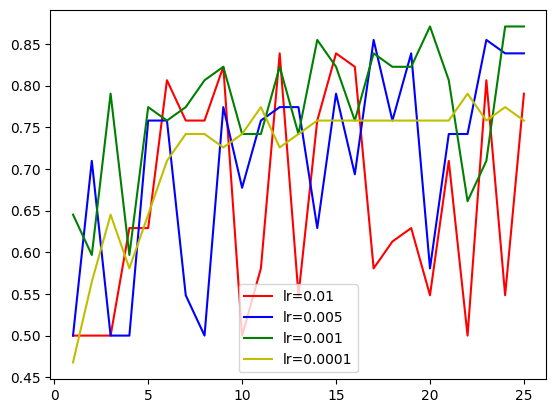

In [128]:
# Epocas del eje X
VGG16_001_val_acc = VGG16_001_val_acc1 + VGG16_001_val_acc2
VGG16_0005_val_acc = VGG16_0005_val_acc1 + VGG16_0005_val_acc2
VGG16_0001_val_acc = VGG16_0001_val_acc1 + VGG16_0001_val_acc2
VGG16_00001_val_acc = VGG16_00001_val_acc1 + VGG16_00001_val_acc2
epochs = range(1, len(VGG16_001_val_acc) + 1)

# Representamos las gráficas
plt.plot(epochs, VGG16_001_val_acc, 'r', label='lr=0.01')
plt.plot(epochs, VGG16_0005_val_acc, 'b', label='lr=0.005')
plt.plot(epochs, VGG16_0001_val_acc, 'g', label='lr=0.001')
plt.plot(epochs, VGG16_00001_val_acc, 'y', label='lr=0.0001')

# Incluir leyenda
plt.legend(loc='best')

# Mostrar la figura
plt.show()